<a href="https://colab.research.google.com/github/BDouchet/BMDATA/blob/main/TPTimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load and Process data

I load the data from a zip file. They come from the [University of Fordham](https://www.cis.fordham.edu/wisdm/dataset.php) and represents the accelerometer data while doing various activities. The aim is to determine which activity is done by analysing the sequence. According to the sources, the number of samples is equal to 1,098,207 divided in 6 classes :

*   Walking: 424,400 (38.6%)
*   Jogging: 342,177 (31.2%)
*   Upstairs: 122,869 (11.2%)
*   Downstairs: 100,427 (9.1%)
*   Sitting: 59,939 (5.5%)
*   Standing: 48,395 (4.4%)

I processed with the raw data.

In [ ]:
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from zipfile import ZipFile
from google.colab.patches import cv2_imshow
import tensorflow as tf
from tensorflow.keras import models,optimizers,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from tensorflow.keras.callbacks import TensorBoard

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1i2ZvCv9VHjDfBTyBv7Q2-_HPW3aE4nRG'

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('WISDM_ar_latest.zip')

with ZipFile('WISDM_ar_latest.zip', 'r') as zip:
   zip.extractall()
   print('Done')

Done


I use pandas to handle the time series. While displaying the values, I observe z-axis is not in the correct format because of the semicolon.

In [ ]:
import pandas as pd
columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
df = pd.read_csv("/content/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt",
                 header = None,
                 sep=',',
                 names=columnNames)

print(df[:10])

   user_id activity       timestamp    x-axis     y-axis        z-axis
0       33  Jogging  49105962326000 -0.694638  12.680544   0.50395286;
1       33  Jogging  49106062271000  5.012288  11.264028   0.95342433;
2       33  Jogging  49106112167000  4.903325  10.882658  -0.08172209;
3       33  Jogging  49106222305000 -0.612916  18.496431    3.0237172;
4       33  Jogging  49106332290000 -1.184970  12.108489     7.205164;
5       33  Jogging  49106442306000  1.375655  -2.492524    -6.510526;
6       33  Jogging  49106542312000 -0.612916  10.569390     5.706926;
7       33  Jogging  49106652389000 -0.503953  13.947236    7.0553403;
8       33  Jogging  49106762313000 -8.430995  11.413852     5.134871;
9       33  Jogging  49106872299000  0.953424   1.375655    1.6480621;


As a result, I process z-axis column and take off the semicolon to each sample. I convert this data to numerical values. I noticed the presence of a NaN value so I used linear interpolation replace it. Now, I ave a clean dataset to process the next operations.

In [ ]:
df['z-axis']=df['z-axis'].str.replace(';','')
df['z-axis']=pd.to_numeric(df['z-axis'],errors='coerce')

print(df.isnull().sum())

df=df.interpolate()

print(df.describe())

print(df.isnull().sum())

user_id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64
            user_id     timestamp        x-axis        y-axis        z-axis
count  1.098204e+06  1.098204e+06  1.098204e+06  1.098204e+06  1.098204e+06
mean   1.886066e+01  3.340907e+13  6.628679e-01  7.255639e+00  4.110666e-01
std    1.021423e+01  4.944967e+13  6.849058e+00  6.746204e+00  4.754110e+00
min    1.000000e+00  0.000000e+00 -1.961000e+01 -1.961000e+01 -1.980000e+01
25%    1.000000e+01  2.019113e+12 -2.870000e+00  3.170000e+00 -2.220000e+00
50%    1.900000e+01  9.722777e+12  2.700000e-01  7.930000e+00  0.000000e+00
75%    2.800000e+01  4.996570e+13  4.440000e+00  1.156000e+01  2.720000e+00
max    3.600000e+01  2.093974e+14  1.995000e+01  2.004000e+01  1.961000e+01
user_id      0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64


Plot of a sequence of x, y and z accelerometer data for each class. The plotted sequence representes the first 180 time steps.

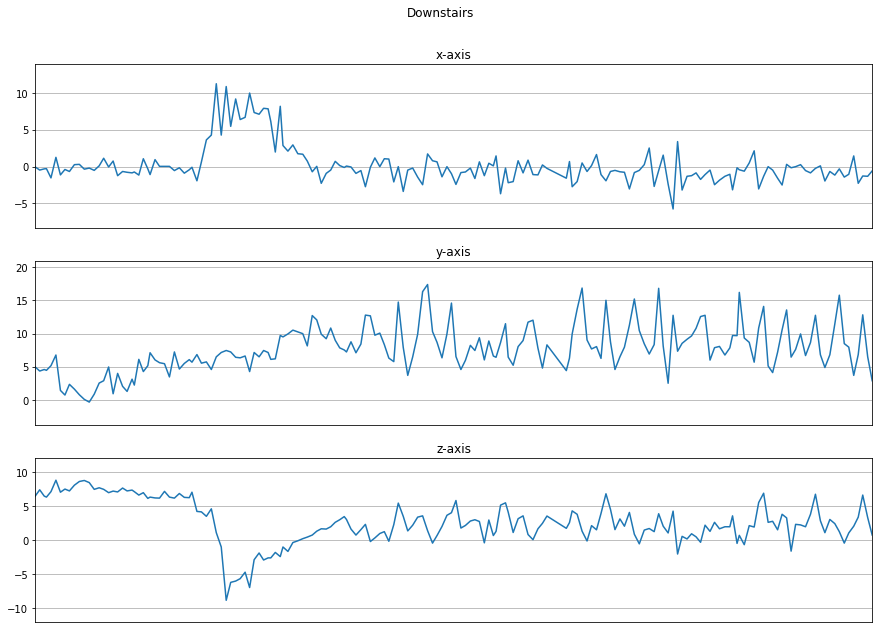

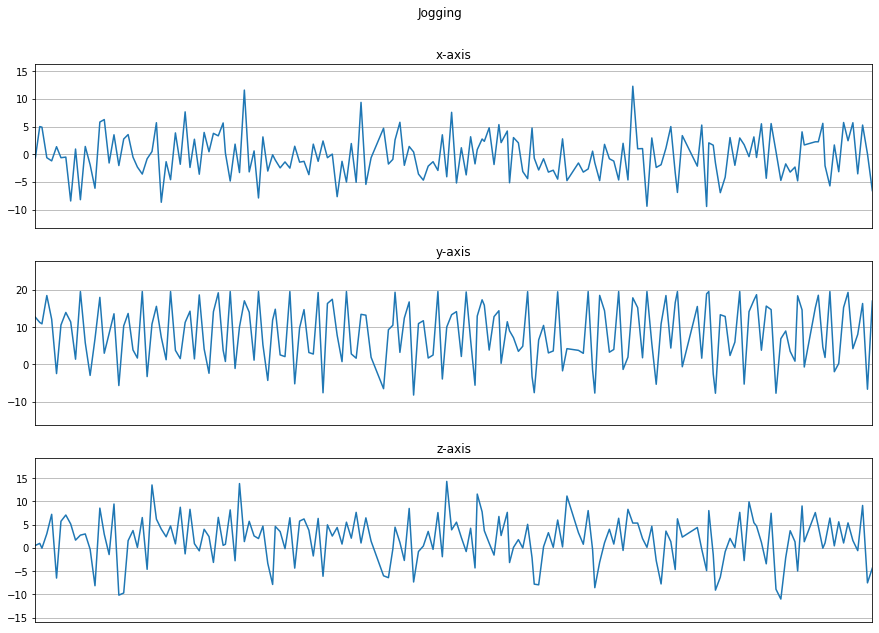

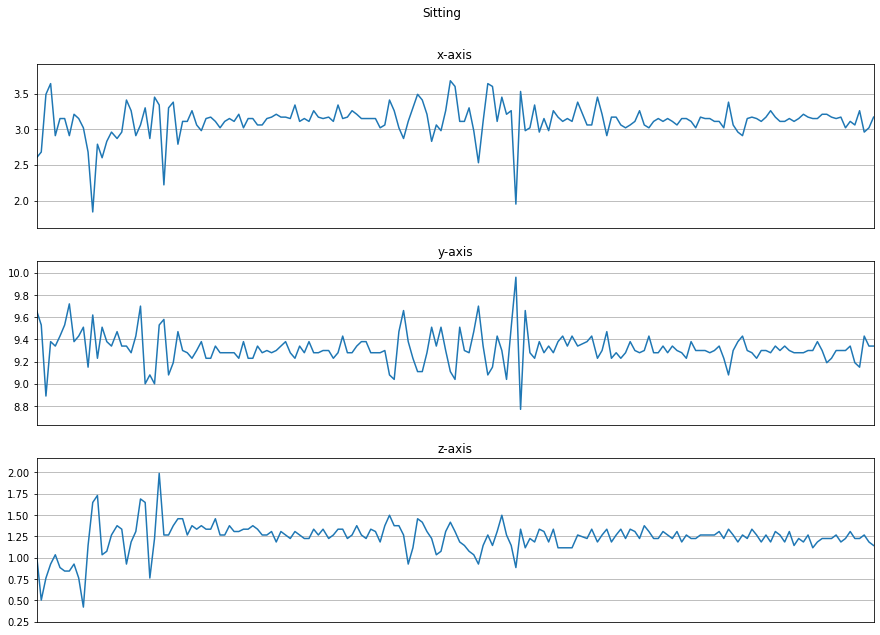

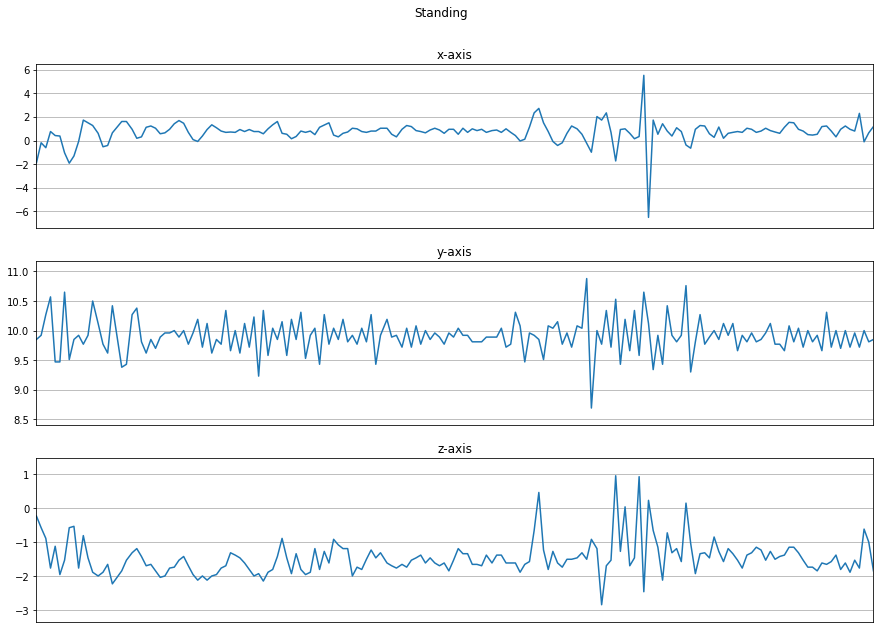

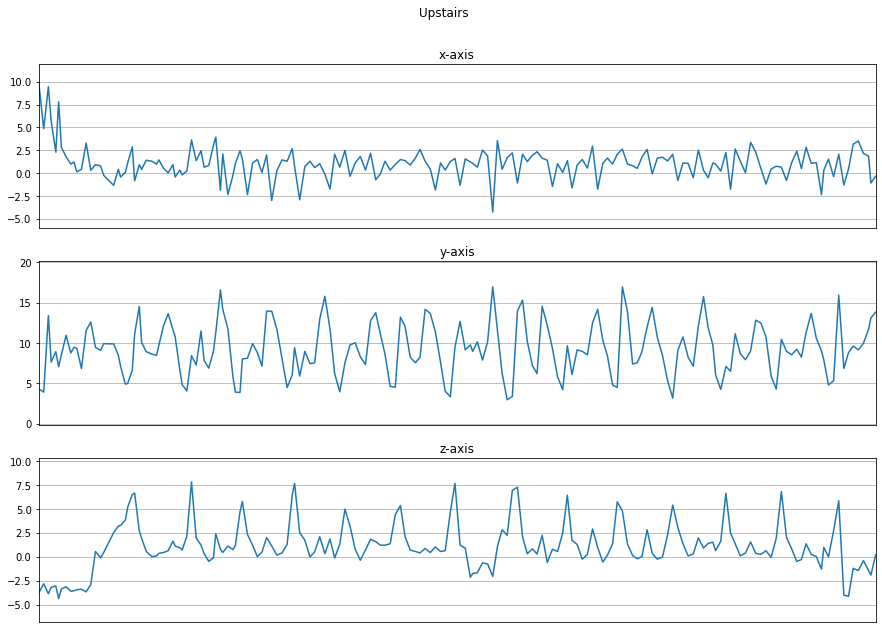

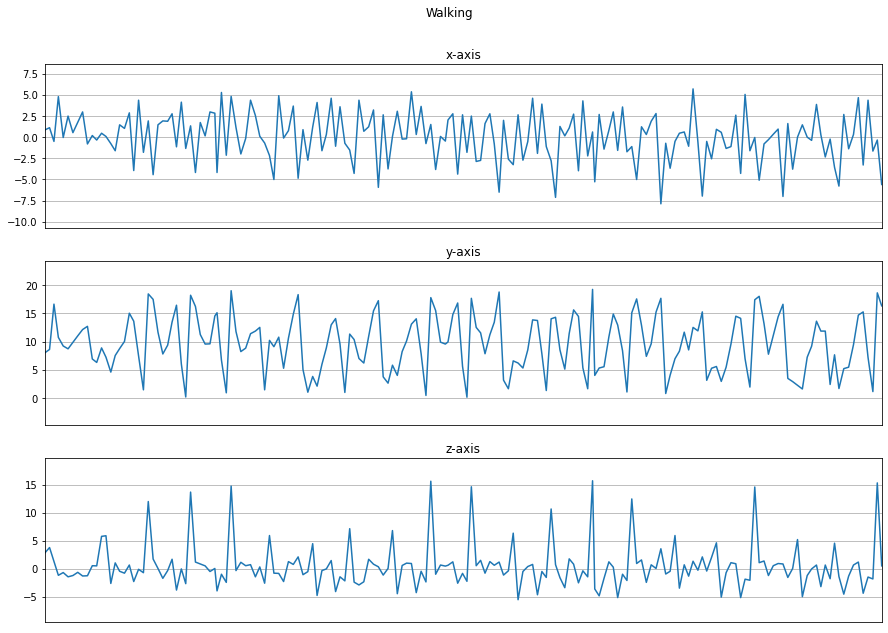

In [ ]:
def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)
    
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

for activity in np.unique(df['activity']):
    subset = df[df['activity']==activity][:180]
    plotActivity(activity,subset)


Standardization of x, y and z data. To be more precise, I should have performed standardization on test dataset with mean and standard deviation from train dataset. However, because of the high quantity of data, the difference is subtle.

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
data_num=sc.fit_transform(df[['x-axis','y-axis','z-axis']])
data=df.copy()
data[['x-axis','y-axis','z-axis']]=pd.DataFrame(data_num)
print(data)

         user_id activity        timestamp    x-axis    y-axis    z-axis
0             33  Jogging   49105962326000 -0.198203  0.804142  0.019538
1             33  Jogging   49106062271000  0.635039  0.594170  0.114082
2             33  Jogging   49106112167000  0.619130  0.537639 -0.103655
3             33  Jogging   49106222305000 -0.186271  1.666240  0.549556
4             33  Jogging   49106332290000 -0.269795  0.719346  1.429100
...          ...      ...              ...       ...       ...       ...
1098199       19  Sitting  131623331483000  1.217268 -1.308238  0.269016
1098200       19  Sitting  131623371431000  1.223108 -1.291933  0.277430
1098201       19  Sitting  131623411592000  1.228948 -1.280074  0.269016
1098202       19  Sitting  131623491487000  1.217268 -1.291933  0.277430
1098203       19  Sitting  131623531465000  1.199747 -1.272663  0.252189

[1098204 rows x 6 columns]


Segmentation of the time series. As an input, we use sequences made of 90 time steps and sampled each 45 time steps. The associated label is the most frequent labels over the time steps.

In [ ]:
from scipy import stats

def windows(data,size):
    start = 0
    while start< data.count():
        if start%100000<size/2:
            print(str(start)+"/"+str(len(data)))
        yield int(start), int(start + size)
        start+= (size/2)

def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,3))
    labels= np.empty((0))
    for (start, end) in windows(data['timestamp'],window_size):
        x = data['x-axis'][start:end]
        y = data['y-axis'][start:end]
        z = data['z-axis'][start:end]
        if len(data['timestamp'][start:end])==window_size :
            segments = np.vstack([segments,np.dstack([x,y,z])])
            labels =np.append(labels,stats.mode(data['activity'][start:end])[0][0])
    return segments, labels

X,Y=segment_signal(data,90)
print(np.array(X).shape,np.array(Y).shape)

0/1098204
100035.0/1098204
200025.0/1098204
300015.0/1098204
400005.0/1098204
500040.0/1098204
600030.0/1098204
700020.0/1098204
800010.0/1098204
900000.0/1098204
1000035.0/1098204
(24403, 90, 3) (24403,)


Conversion from labels to one hot encoding labels.

In [ ]:
#{0:Walking, 1:Jogging, 2:Upstairs, 3:Downstairs, 4:Sitting, 5:Standing}
labels=['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']

def convert1h(Y):
    out=[]
    for label in Y:
        onehot=[0 for _ in range(6)]
        onehot[labels.index(label)]=1
        out.append(onehot)
    return out
Y1h=convert1h(Y)

I split the dataset in two sub datasets : train (19522 sequences) and test (4881 sequences). Because I'll try to apply 2D CNN, it is necessary to add a dimension to our sequences.

In [ ]:
from sklearn.model_selection import train_test_split
X_train,Y_train,X_test,Y_test=train_test_split(X,Y1h,test_size=0.2)
X_train,X_test,Y_train,Y_test=np.array(X_train),np.array(Y_train),np.array(X_test),np.array(Y_test)
print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

#for CNN 2D
X2D_train=np.reshape(X_train,(X_train.shape[0], X_train.shape[1],X_train.shape[2],1))
X2D_test=np.reshape(X_test,(X_test.shape[0], X_test.shape[1],X_test.shape[2],1))
print(X2D_train.shape)

(19522, 90, 3) (19522, 6) (4881, 90, 3) (4881, 6)
(19522, 90, 3, 1)


# Create Train 2D CNN

A classical 2D CNN made of 4 weight layers

In [ ]:
model2D=models.Sequential()
model2D.add(layers.Conv2D(128,2,padding='valid',activation='relu',input_shape=(90,3,1)))
model2D.add(layers.MaxPooling2D())
model2D.add(layers.Dropout(0.2))
model2D.add(layers.Flatten())
model2D.add(layers.Dense(128,activation='relu'))
model2D.add(layers.Dense(128,activation='relu'))
model2D.add(layers.Dense(6,activation='softmax'))

print(model2D.summary())

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 89, 2, 128)        640       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 44, 1, 128)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 44, 1, 128)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 5632)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               721024    
_________________________________________________________________
dense_34 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_35 (Dense)             (None, 6)               

In [ ]:
model2D.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.0001),metrics=['acc'])
history2D=model2D.fit(X2D_train,Y_train,batch_size=128,verbose=1,epochs=50,validation_data=(X2D_test,Y_test))

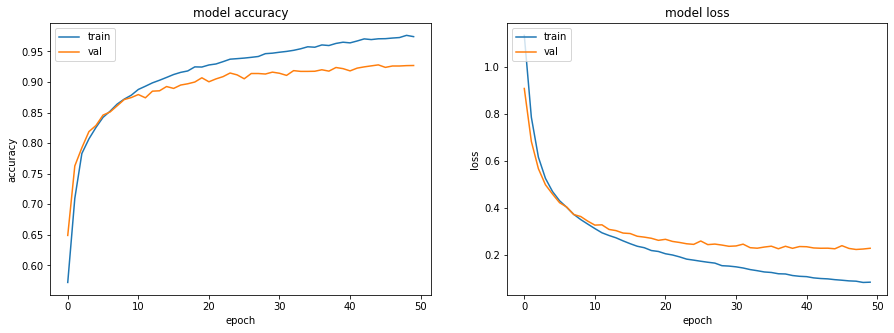

In [ ]:

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history2D.history['acc'])
ax1.plot(history2D.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history2D.history['loss'])
ax2.plot(history2D.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

# Create and Train LSTM

A simple RNN made of LSTM cells.

In [ ]:
RNN=models.Sequential()
RNN.add(layers.LSTM(128,dropout=0.2,return_sequences=True,input_shape=(90,3)))
RNN.add(layers.BatchNormalization())
RNN.add(layers.LSTM(128,return_sequences=False,dropout=0.2))
RNN.add(layers.BatchNormalization())
RNN.add(layers.Dense(32,activation='relu'))
RNN.add(layers.Dropout(0.2))
RNN.add(layers.Dense(6,activation='softmax'))

print(RNN.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 128)           67584     
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1

In [ ]:
RNN.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.0001),metrics=['acc'])
historyRNN=RNN.fit(X_train,Y_train,batch_size=128,verbose=1,epochs=50,validation_data=(X_test,Y_test))

Epoch 1/50
153/153 [==============================] - 89s 579ms/step - loss: 1.2235 - acc: 0.5924 - val_loss: 1.5667 - val_acc: 0.5601
Epoch 2/50
153/153 [==============================] - 87s 571ms/step - loss: 0.8599 - acc: 0.7235 - val_loss: 0.9991 - val_acc: 0.7007
Epoch 3/50
153/153 [==============================] - 87s 567ms/step - loss: 0.7154 - acc: 0.7670 - val_loss: 0.7083 - val_acc: 0.7541
Epoch 4/50
153/153 [==============================] - 86s 564ms/step - loss: 0.6352 - acc: 0.7868 - val_loss: 0.5231 - val_acc: 0.8240
Epoch 5/50
153/153 [==============================] - 86s 564ms/step - loss: 0.5730 - acc: 0.8086 - val_loss: 0.5087 - val_acc: 0.8095
Epoch 6/50
153/153 [==============================] - 87s 567ms/step - loss: 0.5269 - acc: 0.8187 - val_loss: 0.4781 - val_acc: 0.8343
Epoch 7/50
153/153 [==============================] - 86s 565ms/step - loss: 0.4962 - acc: 0.8275 - val_loss: 0.3969 - val_acc: 0.8586
Epoch 8/50
153/153 [==============================] - 8

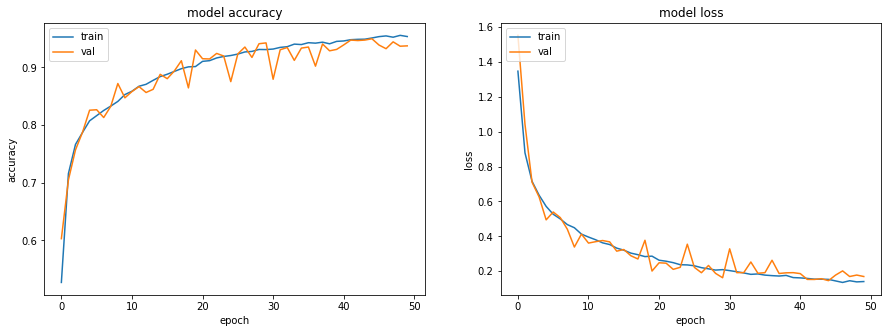

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(historyRNN.history['acc'])
ax1.plot(historyRNN.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(historyRNN.history['loss'])
ax2.plot(historyRNN.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

# Create and Train Conv1D

Similar to CNN2D with Conv1D

In [ ]:
model1D=models.Sequential()
model1D.add(layers.Conv1D(100,5,input_shape=(90,3),padding='valid',activation='relu'))
model1D.add(layers.Conv1D(100,5,padding='valid',activation='relu'))
model1D.add(layers.MaxPool1D(3))
model1D.add(layers.Conv1D(160,5,padding='valid',activation='relu'))
model1D.add(layers.Conv1D(160,5,padding='valid',activation='relu'))
model1D.add(layers.GlobalAvgPool1D())
model1D.add(layers.Dropout(0.2))
model1D.add(layers.Dense(6,activation='softmax'))

print(model1D.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_40 (Conv1D)           (None, 86, 100)           1600      
_________________________________________________________________
conv1d_41 (Conv1D)           (None, 82, 100)           50100     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 27, 100)           0         
_________________________________________________________________
conv1d_42 (Conv1D)           (None, 23, 160)           80160     
_________________________________________________________________
conv1d_43 (Conv1D)           (None, 19, 160)           128160    
_________________________________________________________________
global_average_pooling1d_10  (None, 160)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 160)             

In [ ]:
model1D.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.0001),metrics=['acc'])
history1D=model1D.fit(X_train,Y_train,batch_size=128,verbose=1,epochs=50,validation_data=(X_test,Y_test))

Epoch 1/50
153/153 [==============================] - 1s 7ms/step - loss: 1.0298 - acc: 0.6139 - val_loss: 0.6752 - val_acc: 0.7294
Epoch 2/50
153/153 [==============================] - 1s 5ms/step - loss: 0.5729 - acc: 0.7842 - val_loss: 0.4740 - val_acc: 0.8101
Epoch 3/50
153/153 [==============================] - 1s 5ms/step - loss: 0.4091 - acc: 0.8521 - val_loss: 0.3514 - val_acc: 0.8797
Epoch 4/50
153/153 [==============================] - 1s 5ms/step - loss: 0.3333 - acc: 0.8815 - val_loss: 0.2977 - val_acc: 0.8951
Epoch 5/50
153/153 [==============================] - 1s 5ms/step - loss: 0.2842 - acc: 0.9008 - val_loss: 0.2479 - val_acc: 0.9217
Epoch 6/50
153/153 [==============================] - 1s 5ms/step - loss: 0.2516 - acc: 0.9135 - val_loss: 0.2250 - val_acc: 0.9305
Epoch 7/50
153/153 [==============================] - 1s 5ms/step - loss: 0.2214 - acc: 0.9261 - val_loss: 0.1993 - val_acc: 0.9351
Epoch 8/50
153/153 [==============================] - 1s 5ms/step - loss: 0.

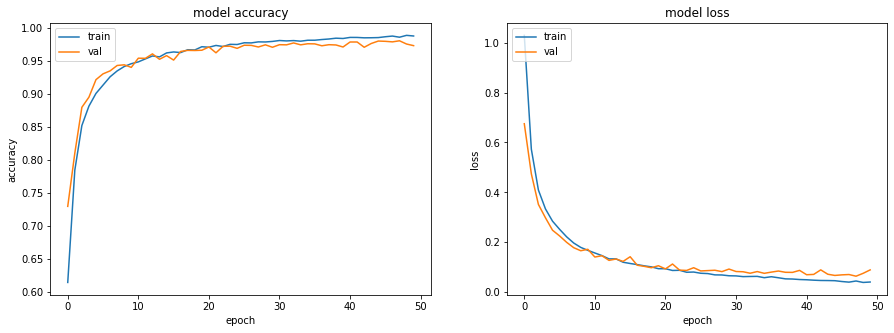

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(history1D.history['acc'])
ax1.plot(history1D.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history1D.history['loss'])
ax2.plot(history1D.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

# Comparison of the models

I compare the performance of these three models and I observe that CNN 1D better fit our data.

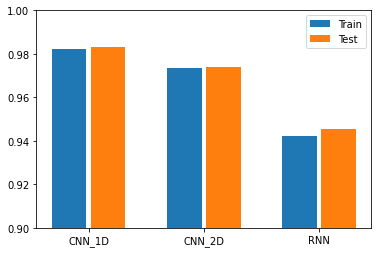

In [ ]:
model1D=models.load_model("model1D.h5")
model2D=models.load_model("model2D.h5")
modelRNN=models.load_model("modelRNN.h5")

acc=[model1D.evaluate(X_train,Y_train,verbose=0)[1],model1D.evaluate(X_test,Y_test,verbose=0)[1],
   model2D.evaluate(X2D_train,Y_train,verbose=0)[1],model2D.evaluate(X2D_test,Y_test,verbose=0)[1],
   modelRNN.evaluate(X_train,Y_train,verbose=0)[1],modelRNN.evaluate(X_test,Y_test,verbose=0)[1]]

names=["CNN_1D","CNN_2D","RNN"]
x=np.arange(3)

train=[acc[0],acc[2],acc[4]]
test=[acc[1],acc[3],acc[5]]
plt.bar(x-0.17,train,width=0.3,color='tab:blue',label="Train")
plt.bar(x+0.17,test,width=0.3,color='tab:orange',label="Test")
plt.xticks(ticks=x, labels=np.array(names))
plt.ylim([0.90,1.00])
plt.legend(loc='upper right')
plt.show()

# Apply RNN to Florence 3D dataset

I apply the previous RNN to another dataset made of sequence of posture and I attempt to predict the final class. The dataset comes from [MICC](https://www.micc.unifi.it/resources/datasets/florence-3d-actions-dataset/) (Media Intergration and Communication Center). It is composed of 215 sequences of various length. Each time step is a "photo" of the skeleton represented as a matrix of size (15 x 3). 15 stands for the number of attention points on the skeleton (ex: neck, shoulder...) and 3 for the localisation in 3D-space. Action are divided in 9 categories :  wave, drink from a bottle, answer phone,clap, tight lace, sit down, stand up, read watch, bow.

Contrary to the previous example, we use padding and masking for the RNN.

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

id='1pxtsBG7C5iH53dNqDtELKcklZt_merj1'

dl = drive.CreateFile({'id':id})
dl.GetContentFile('Data.zip')

with ZipFile('Data.zip', 'r') as zip:
   zip.extractall()
   print('Done')

Done


Read the .mat files. The subject_labels file was not used.

In [ ]:
import scipy.io
seq = np.array(scipy.io.loadmat('sequences.mat')['sequences'][0])
act = np.array(scipy.io.loadmat('action_labels.mat')['labels'][0])
#sub = np.array(scipy.io.loadmat('subject_labels.mat')['subject_labels'][0])

print(seq.shape,act.shape)
print(seq[0].shape,seq[1].shape,seq[2].shape)
print(act[0],act[1],act[2])
#print(sub[0],sub[1],sub[2])

(215,) (215,)
(27, 15, 3) (30, 15, 3) (31, 15, 3)
0 0 0


Get the longest sequence to pad the other sequences by this value.

In [ ]:
print(max([seq[i].shape[0] for i in range(215)]))

35


Padding of the sequences to standardize the length of the sequence. I pad with -inf value, then a mask will be applied and the network will not work with masked values.

The second algorithm flatten the (15x3) matrix to avector of length 45.

In [ ]:
def pad(seq):
    seq=tf.keras.preprocessing.sequence.pad_sequences(seq, maxlen=35,padding="post",value=-np.inf,dtype='float')
    return seq
seq_pad=pad(seq)
print(seq_pad.shape)

def flatt(seq):
    out=[]
    for s in seq:
        out.append(np.reshape(s,(35,45)))
    return np.array(out)

seq_pad=flatt(seq_pad)
print(seq_pad.shape)

print(seq_pad[0][0])
print(seq_pad[0][-1])


(215, 35, 15, 3)
(215, 35, 45)
[-0.22273712  2.83240991  0.54099542 -0.23313617  2.80875928  0.28888602
 -0.2266044   2.79697852  0.08511418 -0.38827069  2.83035205  0.28266495
 -0.48323303  2.8647876   0.03283987 -0.60612299  2.72130591 -0.20737299
 -0.07800165  2.78716675  0.29510709  0.02401169  2.84850757  0.05930406
  0.18601868  2.70788794 -0.18127321 -0.31545218  2.79847314 -0.12248249
 -0.34894778  2.79553076 -0.5667699  -0.37674826  2.84771655 -0.97720502
 -0.1246931   2.77192212 -0.11483284 -0.07861312  2.77143604 -0.54202765
 -0.01819173  2.82743799 -0.9302962 ]
[-inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf -inf
 -inf -inf -inf]


Conversion from labels to one-hot encoded labels

In [ ]:
def act_1h(act):
    out=[]
    for i in act:
        oneh=[0 for _ in range(9)]
        oneh[i]=1
        out.append(oneh)
    return np.array(out)
act=act_1h(act)
print(act.shape)


(215, 9)


The used recurrent neural network. I added a mask layer.

In [ ]:
flo=models.Sequential()
flo.add(layers.Input(shape=(35,45)))
flo.add(layers.Masking(mask_value=-np.inf))
flo.add(layers.LSTM(128,dropout=0.1,return_sequences=True,input_shape=(90,3)))
flo.add(layers.BatchNormalization())
flo.add(layers.LSTM(128,return_sequences=False,dropout=0.1))
flo.add(layers.BatchNormalization())
flo.add(layers.Dense(32,activation='relu'))
flo.add(layers.Dropout(0.1))
flo.add(layers.Dense(9,activation='softmax'))
print(flo.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking (Masking)            (None, 35, 45)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 35, 128)           89088     
_________________________________________________________________
batch_normalization (BatchNo (None, 35, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0

Split to train and test dataset. 

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test=train_test_split(seq_pad,act,test_size=0.2,shuffle=True)
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(172, 35, 45) (43, 35, 45) (172, 9) (43, 9)


In [ ]:
flo.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(0.0001),metrics=['acc'])
historyflo=flo.fit(X_train,Y_train,verbose=2,batch_size=16,epochs=1000,validation_data=(X_test,Y_test))

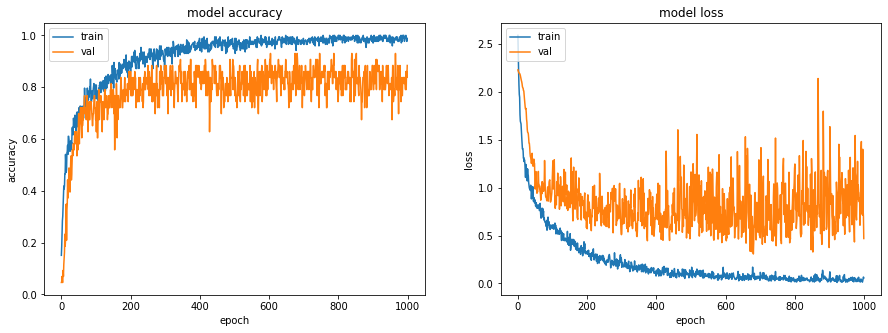

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))

ax1.plot(historyflo.history['acc'])
ax1.plot(historyflo.history['val_acc'])
ax1.set_title('model accuracy')
ax1.set_ylabel('accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(historyflo.history['loss'])
ax2.plot(historyflo.history['val_loss'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'val'], loc='upper left')

plt.show()

In [ ]:
predictions=flo.predict(X_test)
print(predictions.shape)

(43, 9)


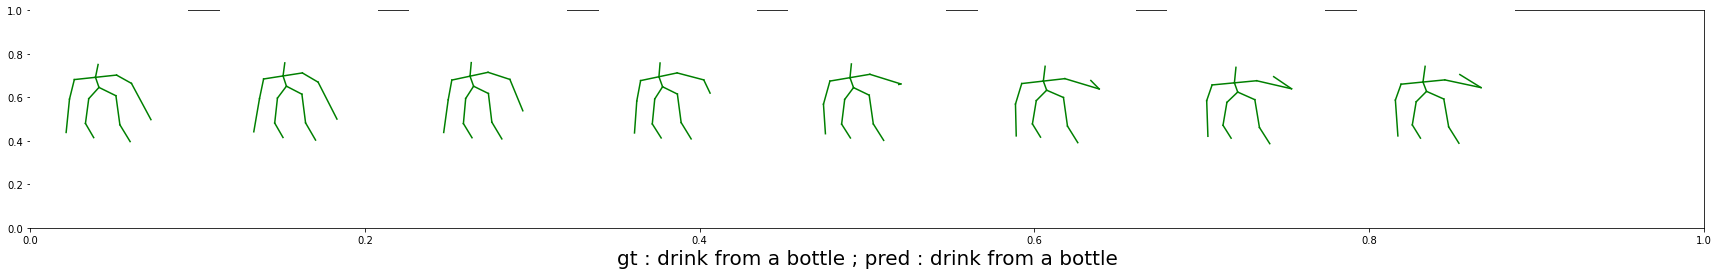

In [ ]:
links = [
    (1, 2), (2, 3), (2, 4), (2, 7),
    (4, 5), (5, 6), (7, 8), (8, 9),
    (3, 10), (3, 13), (10, 11),
    (11, 12), (13, 14), (14, 15)
]

links = [(i-1, j-1) for i, j in links] # Thx Matlab and your index starting at 1

def display_seq(index,limit=None):
    sequence=X_test[index]
    sequence=np.reshape(sequence,(sequence.shape[0],15,3))
    action=Y_test[index]
    pred=predictions[index]
    labels=['wave', 'drink from a bottle', 'answer phone','clap', 'tight lace', 'sit down', 'stand up', 'read watch', 'bow']
    if limit==None:
        n=sequence.shape[0]
        step=1
    else:
        n=limit
        step=sequence.shape[0]//limit
    fig = plt.figure(figsize=(30,4))
    plt.xlabel('gt : '+labels[np.argmax(action)]+' ; pred : '+labels[np.argmax(pred)],size=20)
    for i in range(n):
        sklt=sequence[i+step]
        ax=fig.add_subplot(1,n+1,i+1,projection='3d')
        ax.axis("off")
        for link in links:
            x = [sklt[link[0]][0], sklt[link[1]][0]]
            y = [sklt[link[0]][1], sklt[link[1]][1]]
            z = [sklt[link[0]][2], sklt[link[1]][2]]
            ax.plot(x, y,z, color="green")
    plt.show()

display_seq(0,8)